# Navigation

---

### 1. Start the Environment


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [1]:
from mlagents.envs import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt

# env_name = 'maze_architecture_win'
env_name = 'aug_22_vcs'

# please do not modify the line below
# env = UnityEnvironment(file_name="Banana")
env = UnityEnvironment(file_name="C:/data/ml-agents/scripts/envs/%s/Unity Environment.exe" % env_name, worker_id=0, seed=1)

INFO:mlagents.envs:
'StationAcademy' started successfully!
Unity Academy name: StationAcademy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: MazeLearningBrain
        Number of Visual Observations (per agent): 2
        Vector Observation space size (per agent): 3
        Number of stacked Vector Observation: 6
        Vector Action space type: discrete
        Vector Action space size (per agent): [3, 3, 3]
        Vector Action descriptions: , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

### See initial image

In [4]:
img = np.asarray(env_info.visual_observations)
# imgplt = plt.imshow(img[0][0])
height, width, channel = img[0][0].shape
img[0][0].shape

(300, 300, 3)

In [5]:
import torch
import time
import cv2

from collections import deque
from agent import Agent
%matplotlib inline

model_weight_name = 'checkpoint.pth'
agent = Agent(state_size=300, action_size=9, seed=0)

### 3. DQN Agent Training

In [6]:
def get_action(action):
    move_forward  = action / 3
    rotate = action % 3
    move_side = 100
    return [move_forward, rotate, move_side]
    
def dqn(env_info, n_episodes=1, max_t=1000, eps_start=1.0, eps_end=0.01, 
        eps_decay=0.995, target_scores=1.0):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target_scores (float): average scores aming to achieve, the agent will stop training once it reaches this scores
    """
    start = time.time()                # Start time
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    width, height, channel = [300, 300, 3]
    video = cv2.VideoWriter('output_aug_18.avi',-1,30,(width, height))
    
    for i_episode in range(1, n_episodes+1):
        
        print("episode", i_episode)

        # Reset env and score at the beginning of episode
        # env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        # state = env_info.vector_observations[0]               # get the current state
        
        state = np.transpose(np.asarray(env_info.visual_observations)[0][0], (2, 0, 1))  # get the current visual state
        score = 0                                               # initialize the score
        
        for t in range(max_t):
            print(str(t))
            video.write(np.asarray(env_info.visual_observations)[0][0])
            action = agent.act(state, eps)
            
            # translate action variable into forward, rotate, and right
            action_transformed = get_action(action)
            env_info = env.step(action_transformed)[brain_name]        # send the action to the environment
            print(env_info.vector_observations)
            next_state = np.transpose(np.asarray(env_info.visual_observations)[0][0], 
                                      (2, 0, 1)) # get the next state

            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            
            score += reward
            
            # print('t:%s, position:%s, score:%s' % 
            #       (str(t), str(env_info.vector_observations[0]), str(score)))

            if done:
                break
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            # break to test
            break
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window)>=target_scores:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, 
                                                                             np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), model_weight_name)
            break
    
    cv2.destroyAllWindows()
    video.release()
    
    time_elapsed = time.time() - start
    print("Time Elapse: {:.2f}".format(time_elapsed))
    
    return scores

In [7]:
scores = dqn(env_info, n_episodes=1, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_scores=1.0)

episode 1
0
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.0990042  0.05       5.84942532]]
1
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.0990042  0.05       5.84942532 0.05818466 0.05       5.84438038]]
2
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.0990042  0.05       5.84942532
  0.05818466 0.05       5.84438038 0.06823549 0.05       5.84372377]]
3
[[0.         0.         0.         0.         0.         0.
  0.0990042  0.05       5.84942532 0.05818466 0.05       5.84438038
  0.06823549 0.05       5.84372377 0.14664216 0.05       5.85830402]]
learning!
4
[[0.         0.         0.         0.0990042  0.05       5.84942532
  0.05818466 0.05       5.84438038 0.06823549 0.05       5.84372377
  0.14664216 0.05       5.85830402 0.1942212  0.05       5

  0.32820064 0.05000001 5.74921465 0.3212319  0.05       5.74889755]]
learning!
40
[[0.29582667 0.05       5.7171917  0.29582667 0.05       5.7171917
  0.30884153 0.05000001 5.75026417 0.32820064 0.05000001 5.74921465
  0.3212319  0.05       5.74889755 0.35442126 0.05       5.72888088]]
41
[[0.29582667 0.05       5.7171917  0.30884153 0.05000001 5.75026417
  0.32820064 0.05000001 5.74921465 0.3212319  0.05       5.74889755
  0.35442126 0.05       5.72888088 0.44420424 0.05       5.69843483]]
42
[[0.30884153 0.05000001 5.75026417 0.32820064 0.05000001 5.74921465
  0.3212319  0.05       5.74889755 0.35442126 0.05       5.72888088
  0.44420424 0.05       5.69843483 0.45668048 0.05000001 5.68863773]]
43
[[0.32820064 0.05000001 5.74921465 0.3212319  0.05       5.74889755
  0.35442126 0.05       5.72888088 0.44420424 0.05       5.69843483
  0.45668048 0.05000001 5.68863773 0.44882074 0.05       5.69017506]]
learning!
44
[[0.3212319  0.05       5.74889755 0.35442126 0.05       5.72888088
  0.

   0.04146595  0.05        5.72540951  0.05349936  0.05        5.69899654]]
75
[[-0.04810367  0.05        5.72119093 -0.01105131  0.05        5.74258327
   0.01609185  0.05        5.75825405  0.04146595  0.05        5.72540951
   0.05349936  0.05        5.69899654  0.0126799   0.05        5.70404148]]
learning!
76
[[-0.01105131  0.05        5.74258327  0.01609185  0.05        5.75825405
   0.04146595  0.05        5.72540951  0.05349936  0.05        5.69899654
   0.0126799   0.05        5.70404148 -0.0780765   0.05        5.67128038]]
77
[[ 0.01609185  0.05        5.75825405  0.04146595  0.05        5.72540951
   0.05349936  0.05        5.69899654  0.0126799   0.05        5.70404148
  -0.0780765   0.05        5.67128038 -0.20482251  0.05        5.62857199]]
78
[[ 0.04146595  0.05        5.72540951  0.05349936  0.05        5.69899654
   0.0126799   0.05        5.70404148 -0.0780765   0.05        5.67128038
  -0.20482251  0.05        5.62857199 -0.25352567  0.05        5.57736254]]
79
[[ 

  -0.55328757  0.05        5.28085279 -0.47935981  0.05        5.34516668]]
111
[[-0.5208323   0.05        5.26162434 -0.56165195  0.05        5.25657988
  -0.59034014  0.05000001  5.25946093 -0.55328757  0.05        5.28085279
  -0.47935981  0.05        5.34516668 -0.44219828  0.05        5.39708042]]
learning!
112
[[-0.56165195  0.05        5.25657988 -0.59034014  0.05000001  5.25946093
  -0.55328757  0.05        5.28085279 -0.47935981  0.05        5.34516668
  -0.44219828  0.05        5.39708042 -0.4700827   0.05        5.38319683]]
113
[[-0.59034014  0.05000001  5.25946093 -0.55328757  0.05        5.28085279
  -0.47935981  0.05        5.34516668 -0.44219828  0.05        5.39708042
  -0.4700827   0.05        5.38319683 -0.4911291   0.05        5.37130737]]
114
[[-0.55328757  0.05        5.28085279 -0.47935981  0.05        5.34516668
  -0.44219828  0.05        5.39708042 -0.4700827   0.05        5.38319683
  -0.4911291   0.05        5.37130737 -0.51590812  0.05        5.33847904]]
11

   5.00000045e-02  5.44623375e+00]]
143
[[-5.01453178e-03  5.00000045e-02  5.55233002e+00  4.68153991e-02
   5.00000007e-02  5.49171734e+00  7.33647719e-02  5.00000045e-02
   5.44532871e+00  3.85449380e-02  5.00000119e-02  5.44618893e+00
   5.14236800e-02  5.00000045e-02  5.44623375e+00  6.66266233e-02
   5.00000045e-02  5.44316721e+00]]
learning!
144
[[0.0468154  0.05       5.49171734 0.07336477 0.05       5.44532871
  0.03854494 0.05000001 5.44618893 0.05142368 0.05       5.44623375
  0.06662662 0.05       5.44316721 0.0914057  0.05       5.47599506]]
145
[[0.07336477 0.05       5.44532871 0.03854494 0.05000001 5.44618893
  0.05142368 0.05       5.44623375 0.06662662 0.05       5.44316721
  0.0914057  0.05       5.47599506 0.10325518 0.05       5.50228024]]
146
[[0.03854494 0.05000001 5.44618893 0.05142368 0.05       5.44623375
  0.06662662 0.05       5.44316721 0.0914057  0.05       5.47599506
  0.10325518 0.05       5.50228024 0.06620265 0.05       5.48088789]]
147
[[0.05142368 0.0

  -0.16618736  0.05        5.9143877  -0.10886425  0.05        5.97101593]]
178
[[-0.05619247  0.05        5.89632893 -0.11116566  0.05        5.89142704
  -0.16776533  0.05000001  5.89810085 -0.16618736  0.05        5.9143877
  -0.10886425  0.05        5.97101593 -0.08053374  0.05        6.01614094]]
179
[[-0.11116566  0.05        5.89142704 -0.16776533  0.05000001  5.89810085
  -0.16618736  0.05        5.9143877  -0.10886425  0.05        5.97101593
  -0.08053374  0.05        6.01614094 -0.07941665  0.05        6.01792049]]
learning!
180
[[-0.16776533  0.05000001  5.89810085 -0.16618736  0.05        5.9143877
  -0.10886425  0.05        5.97101593 -0.08053374  0.05        6.01614094
  -0.07941665  0.05        6.01792049 -0.07941665  0.05        6.01792049]]
181
[[-0.16618736  0.05        5.9143877  -0.10886425  0.05        5.97101593
  -0.08053374  0.05        6.01614094 -0.07941665  0.05        6.01792049
  -0.07941665  0.05        6.01792049 -0.12023614  0.05000001  6.02296543]]
182


  -0.90261     0.05        5.66832685 -0.89815342  0.05        5.65929461]]
214
[[-0.87783194  0.05        5.63549805 -0.87783194  0.05        5.63549805
  -0.87783194  0.05        5.63549805 -0.90261     0.05        5.66832685
  -0.89815342  0.05        5.65929461 -0.8885392   0.05        5.64851284]]
215
[[-0.87783194  0.05        5.63549805 -0.87783194  0.05        5.63549805
  -0.90261     0.05        5.66832685 -0.89815342  0.05        5.65929461
  -0.8885392   0.05        5.64851284 -0.84771967  0.05        5.64346743]]
learning!
216
[[-0.87783194  0.05        5.63549805 -0.90261     0.05        5.66832685
  -0.89815342  0.05        5.65929461 -0.8885392   0.05        5.64851284
  -0.84771967  0.05        5.64346743 -0.85777062  0.05        5.6428113 ]]
217
[[-0.90261     0.05        5.66832685 -0.89815342  0.05        5.65929461
  -0.8885392   0.05        5.64851284 -0.84771967  0.05        5.64346743
  -0.85777062  0.05        5.6428113  -0.9361769   0.05000001  5.65739346]]
21

  -0.71213257  0.05        6.34977198 -0.71213257  0.05000001  6.34977198]]
250
[[-0.67958558  0.05        6.28757429 -0.69527227  0.05        6.32609272
  -0.71213257  0.05        6.34977198 -0.71213257  0.05        6.34977198
  -0.71213257  0.05000001  6.34977198 -0.75295204  0.05        6.35481739]]
251
[[-0.69527227  0.05        6.32609272 -0.71213257  0.05        6.34977198
  -0.71213257  0.05        6.34977198 -0.71213257  0.05000001  6.34977198
  -0.75295204  0.05        6.35481739 -0.84370935  0.05        6.32205963]]
learning!
252
[[-0.71213257  0.05        6.34977198 -0.71213257  0.05        6.34977198
  -0.71213257  0.05000001  6.34977198 -0.75295204  0.05        6.35481739
  -0.84370935  0.05        6.32205963 -0.9508847   0.05        6.24587774]]
253
[[-0.71213257  0.05        6.34977198 -0.71213257  0.05000001  6.34977198
  -0.75295204  0.05        6.35481739 -0.84370935  0.05        6.32205963
  -0.9508847   0.05        6.24587774 -0.98352146  0.05        6.23187399]]
25

  -1.50896931  0.05        6.43059635 -1.5166136   0.05        6.51222706]]
286
[[-1.54198503  0.05        6.43451023 -1.50493324  0.05        6.41311741
  -1.51658499  0.05        6.40616226 -1.50896931  0.05        6.43059635
  -1.5166136   0.05        6.51222706 -1.53732133  0.05        6.56030798]]
287
[[-1.50493324  0.05        6.41311741 -1.51658499  0.05        6.40616226
  -1.50896931  0.05        6.43059635 -1.5166136   0.05        6.51222706
  -1.53732133  0.05        6.56030798 -1.52274108  0.05        6.5300622 ]]
learning!
288
[[-1.51658499  0.05        6.40616226 -1.50896931  0.05        6.43059635
  -1.5166136   0.05        6.51222706 -1.53732133  0.05        6.56030798
  -1.52274108  0.05        6.5300622  -1.54082596  0.05        6.53239679]]
289
[[-1.50896931  0.05        6.43059635 -1.5166136   0.05        6.51222706
  -1.53732133  0.05        6.56030798 -1.52274108  0.05        6.5300622
  -1.54082596  0.05        6.53239679 -1.52505183  0.05        6.52301168]]
290

  -2.14651847  0.05        6.79663229 -2.14651847  0.05        6.79663229]]
322
[[-2.14651847  0.05        6.79663229 -2.14651847  0.05        6.79663229
  -2.14651847  0.05        6.79663229 -2.14651847  0.05        6.79663229
  -2.14651847  0.05        6.79663229 -2.10569906  0.05000001  6.7915864 ]]
323
[[-2.14651847  0.05        6.79663229 -2.14651847  0.05        6.79663229
  -2.14651847  0.05        6.79663229 -2.14651847  0.05        6.79663229
  -2.10569906  0.05000001  6.7915864  -2.01494145  0.05        6.82434368]]
learning!
324
[[-2.14651847  0.05        6.79663229 -2.14651847  0.05        6.79663229
  -2.14651847  0.05        6.79663229 -2.10569906  0.05000001  6.7915864
  -2.01494145  0.05        6.82434368 -1.90776503  0.05        6.90052509]]
325
[[-2.14651847  0.05        6.79663229 -2.14651847  0.05        6.79663229
  -2.10569906  0.05000001  6.7915864  -2.01494145  0.05        6.82434368
  -1.90776503  0.05        6.90052509 -1.85684454  0.05        6.9079504 ]]
326

  -1.88045597  0.05        6.67304707 -1.88045597  0.05        6.67304707]]
358
[[-1.85360718  0.05        6.65754414 -1.84508681  0.05        6.65262461
  -1.86369765  0.05        6.66336966 -1.88045597  0.05        6.67304707
  -1.88045597  0.05        6.67304707 -1.89649832  0.05        6.6351738 ]]
359
[[-1.84508681  0.05        6.65262461 -1.86369765  0.05        6.66336966
  -1.88045597  0.05        6.67304707 -1.88045597  0.05        6.67304707
  -1.89649832  0.05        6.6351738  -1.97434831  0.05        6.592103  ]]
learning!
360
[[-1.86369765  0.05        6.66336966 -1.88045597  0.05        6.67304707
  -1.88045597  0.05        6.67304707 -1.89649832  0.05        6.6351738
  -1.97434831  0.05        6.592103   -2.02919459  0.05        6.58267307]]
361
[[-1.88045597  0.05        6.67304707 -1.88045597  0.05        6.67304707
  -1.89649832  0.05        6.6351738  -1.97434831  0.05        6.592103
  -2.02919459  0.05        6.58267307 -2.03179908  0.05        6.58222437]]
362
[

  -2.28715301  0.05        6.53011608 -2.27111053  0.05        6.56798935]]
394
[[-2.3200798   0.05        6.53650045 -2.28302646  0.05        6.55789042
  -2.28282928  0.05        6.54432154 -2.28715301  0.05        6.53011608
  -2.27111053  0.05        6.56798935 -2.25427055  0.05        6.59139347]]
395
[[-2.28302646  0.05        6.55789042 -2.28282928  0.05        6.54432154
  -2.28715301  0.05        6.53011608 -2.27111053  0.05        6.56798935
  -2.25427055  0.05        6.59139347 -2.27905107  0.05        6.55856609]]
learning!
396
[[-2.28282928  0.05        6.54432154 -2.28715301  0.05        6.53011608
  -2.27111053  0.05        6.56798935 -2.25427055  0.05        6.59139347
  -2.27905107  0.05        6.55856609 -2.31479001  0.05000001  6.46868277]]
397
[[-2.28715301  0.05        6.53011608 -2.27111053  0.05        6.56798935
  -2.25427055  0.05        6.59139347 -2.27905107  0.05        6.55856609
  -2.31479001  0.05000001  6.46868277 -2.29840517  0.05000001  6.42554235]]
39

  -2.40110779  0.05        6.74786997 -2.38190079  0.05        6.73679352]]
430
[[-2.43521404  0.05        6.87143946 -2.41821146  0.05        6.77646112
  -2.4248662   0.05        6.76080561 -2.40110779  0.05        6.74786997
  -2.38190079  0.05        6.73679352 -2.39794302  0.05        6.69892025]]
431
[[-2.41821146  0.05        6.77646112 -2.4248662   0.05        6.76080561
  -2.40110779  0.05        6.74786997 -2.38190079  0.05        6.73679352
  -2.39794302  0.05        6.69892025 -2.414783    0.05        6.67551661]]
learning!
432
[[-2.4248662   0.05        6.76080561 -2.40110779  0.05        6.74786997
  -2.38190079  0.05        6.73679352 -2.39794302  0.05        6.69892025
  -2.414783    0.05        6.67551661 -2.45560288  0.05        6.67047262]]
433
[[-2.40110779  0.05        6.74786997 -2.38190079  0.05        6.73679352
  -2.39794302  0.05        6.69892025 -2.414783    0.05        6.67551661
  -2.45560288  0.05        6.67047262 -2.48429084  0.05        6.67335415]]
43

  -2.62180781 -0.41982025  7.48108768 -2.58036804 -0.53000438  7.3594141 ]]
466
[[-2.64446211 -0.12069     7.60995722 -2.62996578 -0.21276501  7.62286139
  -2.63812089 -0.31343538  7.60662746 -2.62180781 -0.41982025  7.48108768
  -2.58036804 -0.53000438  7.3594141  -2.61954713 -0.64271414  7.29194784]]
467
[[-2.62996578 -0.21276501  7.62286139 -2.63812089 -0.31343538  7.60662746
  -2.62180781 -0.41982025  7.48108768 -2.58036804 -0.53000438  7.3594141
  -2.61954713 -0.64271414  7.29194784 -2.69398165 -0.75710326  7.23970509]]
learning!
468
[[-2.63812089 -0.31343538  7.60662746 -2.62180781 -0.41982025  7.48108768
  -2.58036804 -0.53000438  7.3594141  -2.61954713 -0.64271414  7.29194784
  -2.69398165 -0.75710326  7.23970509 -2.67673826 -0.87260878  7.21839523]]
469
[[-2.62180781 -0.41982025  7.48108768 -2.58036804 -0.53000438  7.3594141
  -2.61954713 -0.64271414  7.29194784 -2.69398165 -0.75710326  7.23970509
  -2.67673826 -0.87260878  7.21839523 -2.61688733 -0.98885643  7.19683361]]
470


  -0.44653219 -4.63527441  6.84214115 -0.46405548 -4.75299597  6.80634785]]
502
[[-0.67924201 -4.28210974  6.99647617 -0.50611895 -4.3998313   6.96021509
  -0.4142378  -4.51755285  6.92441177 -0.44653219 -4.63527441  6.84214115
  -0.46405548 -4.75299597  6.80634785 -0.51183927 -4.87071753  6.80733633]]
503
[[-0.50611895 -4.3998313   6.96021509 -0.4142378  -4.51755285  6.92441177
  -0.44653219 -4.63527441  6.84214115 -0.46405548 -4.75299597  6.80634785
  -0.51183927 -4.87071753  6.80733633 -0.65297478 -4.98843908  6.85059643]]
learning!
504
[[-0.4142378  -4.51755285  6.92441177 -0.44653219 -4.63527441  6.84214115
  -0.46405548 -4.75299597  6.80634785 -0.51183927 -4.87071753  6.80733633
  -0.65297478 -4.98843908  6.85059643 -0.79031879 -5.10616064  6.90448093]]
505
[[-0.44653219 -4.63527441  6.84214115 -0.46405548 -4.75299597  6.80634785
  -0.51183927 -4.87071753  6.80733633 -0.65297478 -4.98843908  6.85059643
  -0.79031879 -5.10616064  6.90448093 -0.9033699  -5.2238822   6.87580347]]
50

  -0.19734557 -8.87325096  7.22214413 -0.1211501  -8.99097252  7.23021221]]
538
[[-0.46101078 -8.52008629  7.17194366 -0.41155988 -8.63780785  7.20287418
  -0.31195411 -8.7555294   7.21001053 -0.19734557 -8.87325096  7.22214413
  -0.1211501  -8.99097252  7.23021221 -0.13722204 -9.10869408  7.24900293]]
539
[[-0.41155988 -8.63780785  7.20287418 -0.31195411 -8.7555294   7.21001053
  -0.19734557 -8.87325096  7.22214413 -0.1211501  -8.99097252  7.23021221
  -0.13722204 -9.10869408  7.24900293 -0.19629458 -9.22641563  7.25410604]]
learning!
540
[[-0.31195411 -8.7555294   7.21001053 -0.19734557 -8.87325096  7.22214413
  -0.1211501  -8.99097252  7.23021221 -0.13722204 -9.10869408  7.24900293
  -0.19629458 -9.22641563  7.25410604 -0.30229706 -9.34413719  7.27092457]]
541
[[-0.19734557 -8.87325096  7.22214413 -0.1211501  -8.99097252  7.23021221
  -0.13722204 -9.10869408  7.24900293 -0.19629458 -9.22641563  7.25410604
  -0.30229706 -9.34413719  7.27092457 -0.42115837 -9.46185875  7.27471685]]
54

   -0.69929671 -12.99350452   7.29345226]]
learning!
572
[[ -0.54496944 -12.52261925   7.14734173  -0.63465512 -12.64034081
    7.22287083  -0.6942811  -12.75806236   7.27308416  -0.73392236
  -12.87578297   7.30646801  -0.69929671 -12.99350452   7.29345226
   -0.63276398 -13.11122608   7.25967693]]
573
[[ -0.63465512 -12.64034081   7.22287083  -0.6942811  -12.75806236
    7.27308416  -0.73392236 -12.87578297   7.30646801  -0.69929671
  -12.99350452   7.29345226  -0.63276398 -13.11122608   7.25967693
   -0.64951128 -13.22894764   7.27243137]]
574
[[ -0.6942811  -12.75806236   7.27308416  -0.73392236 -12.87578297
    7.30646801  -0.69929671 -12.99350452   7.29345226  -0.63276398
  -13.11122608   7.25967693  -0.64951128 -13.22894764   7.27243137
   -0.70415801 -13.3466692    7.30603266]]
575
[[ -0.73392236 -12.87578297   7.30646801  -0.69929671 -12.99350452
    7.29345226  -0.63276398 -13.11122608   7.25967693  -0.64951128
  -13.22894764   7.27243137  -0.70415801 -13.3466692    7.3060326

    0.07575488 -16.87831497   6.69453573]]
605
[[ -0.33254448 -16.40742874   6.48568201  -0.32778633 -16.5251503
    6.56419754  -0.21437883 -16.64287186   6.65494013  -0.0296145
  -16.76059341   6.6726656    0.07575488 -16.87831497   6.69453573
    0.1022953  -16.99603653   6.73419952]]
606
[[ -0.32778633 -16.5251503    6.56419754  -0.21437883 -16.64287186
    6.65494013  -0.0296145  -16.76059341   6.6726656    0.07575488
  -16.87831497   6.69453573   0.1022953  -16.99603653   6.73419952
    0.11994026 -17.11375809   6.76056957]]
607
[[ -0.21437883 -16.64287186   6.65494013  -0.0296145  -16.76059341
    6.6726656    0.07575488 -16.87831497   6.69453573   0.1022953
  -16.99603653   6.73419952   0.11994026 -17.11375809   6.76056957
    0.13167118 -17.23147964   6.77810049]]
learning!
608
[[ -0.0296145  -16.76059341   6.6726656    0.07575488 -16.87831497
    6.69453573   0.1022953  -16.99603653   6.73419952   0.11994026
  -17.11375809   6.76056957   0.13167118 -17.23147964   6.77810049
 

    1.08142018 -20.64540482   7.07302094]]
637
[[  0.40083855 -20.17451859   6.75211573   0.48329329 -20.29224014
    6.75926876   0.64260846 -20.4099617    6.82435131   0.85302305
  -20.52768326   6.92794895   1.08142018 -20.64540482   7.07302094
    1.25105929 -20.76312637   7.21506882]]
638
[[  0.48329329 -20.29224014   6.75926876   0.64260846 -20.4099617
    6.82435131   0.85302305 -20.52768326   6.92794895   1.08142018
  -20.64540482   7.07302094   1.25105929 -20.76312637   7.21506882
    1.40883338 -20.88084793   7.36058283]]
639
[[  0.64260846 -20.4099617    6.82435131   0.85302305 -20.52768326
    6.92794895   1.08142018 -20.64540482   7.07302094   1.25105929
  -20.76312637   7.21506882   1.40883338 -20.88084793   7.36058283
    1.55325663 -20.99856949   7.4384222 ]]
learning!
640
[[  0.85302305 -20.52768326   6.92794895   1.08142018 -20.64540482
    7.07302094   1.25105929 -20.76312637   7.21506882   1.40883338
  -20.88084793   7.36058283   1.55325663 -20.99856949   7.4384222


    3.19966412 -24.53021622   8.16870308]]
670
[[  2.57704663 -24.05932999   7.3998003    2.74638224 -24.17705154
    7.55183125   2.94746828 -24.2947731    7.72910309   3.09895182
  -24.41249466   7.96297359   3.19966412 -24.53021622   8.16870308
    3.26662111 -24.64793777   8.30547905]]
671
[[  2.74638224 -24.17705154   7.55183125   2.94746828 -24.2947731
    7.72910309   3.09895182 -24.41249466   7.96297359   3.19966412
  -24.53021622   8.16870308   3.26662111 -24.64793777   8.30547905
    3.33287668 -24.76565933   8.4609127 ]]
learning!
672
[[  2.94746828 -24.2947731    7.72910309   3.09895182 -24.41249466
    7.96297359   3.19966412 -24.53021622   8.16870308   3.26662111
  -24.64793777   8.30547905   3.33287668 -24.76565933   8.4609127
    3.34653854 -24.88338089   8.56725216]]
673
[[  3.09895182 -24.41249466   7.96297359   3.19966412 -24.53021622
    8.16870308   3.26662111 -24.64793777   8.30547905   3.33287668
  -24.76565933   8.4609127    3.34653854 -24.88338089   8.56725216


    2.97262359 -28.41466331   7.93983603]]
703
[[  3.14029455 -27.94383812   8.04416847   3.0287776  -28.06154442
    7.98710489   2.95463753 -28.17925072   7.94916821   2.9663291
  -28.29695702   7.95915318   2.97262359 -28.41466331   7.93983603
    2.95901537 -28.53236961   7.88139343]]
learning!
704
[[  3.0287776  -28.06154442   7.98710489   2.95463753 -28.17925072
    7.94916821   2.9663291  -28.29695702   7.95915318   2.97262359
  -28.41466331   7.93983603   2.95901537 -28.53236961   7.88139343
    2.94996834 -28.65007591   7.84253979]]
705
[[  2.95463753 -28.17925072   7.94916821   2.9663291  -28.29695702
    7.95915318   2.97262359 -28.41466331   7.93983603   2.95901537
  -28.53236961   7.88139343   2.94996834 -28.65007591   7.84253979
    2.94395375 -28.76778221   7.81670856]]
706
[[  2.9663291  -28.29695702   7.95915318   2.97262359 -28.41466331
    7.93983603   2.95901537 -28.53236961   7.88139343   2.94996834
  -28.65007591   7.84253979   2.94395375 -28.76778221   7.81670856

    3.70334816 -32.29897308   5.65515471]]
learning!
736
[[  3.69804001 -31.82814598   6.55782604   3.68245935 -31.94585228
    6.31198263   3.70269465 -32.06356049   6.11032915   3.71614599
  -32.18126678   5.90584707   3.70334816 -32.29897308   5.65515471
    3.72522664 -32.41667938   5.48548412]]
737
[[  3.68245935 -31.94585228   6.31198263   3.70269465 -32.06356049
    6.11032915   3.71614599 -32.18126678   5.90584707   3.70334816
  -32.29897308   5.65515471   3.72522664 -32.41667938   5.48548412
    3.82827759 -32.53438568   5.44887972]]
738
[[  3.70269465 -32.06356049   6.11032915   3.71614599 -32.18126678
    5.90584707   3.70334816 -32.29897308   5.65515471   3.72522664
  -32.41667938   5.48548412   3.82827759 -32.53438568   5.44887972
    3.91457987 -32.65209198   5.39972878]]
739
[[  3.71614599 -32.18126678   5.90584707   3.70334816 -32.29897308
    5.65515471   3.72522664 -32.41667938   5.48548412   3.82827759
  -32.53438568   5.44887972   3.91457987 -32.65209198   5.3997287

    3.86378932 -36.18328094   8.09977722]]
769
[[  3.72637749 -35.71245575   8.15908337   3.78456235 -35.83016205
    8.17350388   3.85383987 -35.94786835   8.14488125   3.89989805
  -36.06557465   8.12585258   3.86378932 -36.18328094   8.09977722
    3.83638644 -36.30098724   8.03875542]]
770
[[  3.78456235 -35.83016205   8.17350388   3.85383987 -35.94786835
    8.14488125   3.89989805 -36.06557465   8.12585258   3.86378932
  -36.18328094   8.09977722   3.83638644 -36.30098724   8.03875542
    3.81421995 -36.41869354   7.88808537]]
771
[[  3.85383987 -35.94786835   8.14488125   3.89989805 -36.06557465
    8.12585258   3.86378932 -36.18328094   8.09977722   3.83638644
  -36.30098724   8.03875542   3.81421995 -36.41869354   7.88808537
    3.72389674 -36.53639984   7.69862986]]
learning!
772
[[  3.89989805 -36.06557465   8.12585258   3.86378932 -36.18328094
    8.09977722   3.83638644 -36.30098724   8.03875542   3.81421995
  -36.41869354   7.88808537   3.72389674 -36.53639984   7.6986298

    2.90906143 -40.06758881   7.03041983]]
802
[[  3.37686229 -39.59676361   7.30506659   3.33115721 -39.71446991
    7.29759741   3.20919347 -39.83217621   7.21921778   3.03960276
  -39.94988251   7.090909     2.90906143 -40.06758881   7.03041983
    2.82227397 -40.1852951    7.0404501 ]]
803
[[  3.33115721 -39.71446991   7.29759741   3.20919347 -39.83217621
    7.21921778   3.03960276 -39.94988251   7.090909     2.90906143
  -40.06758881   7.03041983   2.82227397 -40.1852951    7.0404501
    2.78631449 -40.3030014    7.1116209 ]]
learning!
804
[[  3.20919347 -39.83217621   7.21921778   3.03960276 -39.94988251
    7.090909     2.90906143 -40.06758881   7.03041983   2.82227397
  -40.1852951    7.0404501    2.78631449 -40.3030014    7.1116209
    2.79300308 -40.4207077    7.19714499]]
805
[[  3.03960276 -39.94988251   7.090909     2.90906143 -40.06758881
    7.03041983   2.82227397 -40.1852951    7.0404501    2.78631449
  -40.3030014    7.1116209    2.79300308 -40.4207077    7.19714499


    4.90921974 -43.95189667   8.27058983]]
835
[[  4.89637041 -43.48107147   8.38345337   4.8456831  -43.59877777
    8.35785007   4.76847029 -43.71648407   8.3157053    4.78386688
  -43.83419037   8.30111122   4.90921974 -43.95189667   8.27058983
    5.08593798 -44.06960297   8.30876732]]
learning!
836
[[  4.8456831  -43.59877777   8.35785007   4.76847029 -43.71648407
    8.3157053    4.78386688 -43.83419037   8.30111122   4.90921974
  -43.95189667   8.27058983   5.08593798 -44.06960297   8.30876732
    5.22121716 -44.18730927   8.3093338 ]]
837
[[  4.76847029 -43.71648407   8.3157053    4.78386688 -43.83419037
    8.30111122   4.90921974 -43.95189667   8.27058983   5.08593798
  -44.06960297   8.30876732   5.22121716 -44.18730927   8.3093338
    5.33289385 -44.30501556   8.32396603]]
838
[[  4.78386688 -43.83419037   8.30111122   4.90921974 -43.95189667
    8.27058983   5.08593798 -44.06960297   8.30876732   5.22121716
  -44.18730927   8.3093338    5.33289385 -44.30501556   8.32396603

    3.31519628 -47.83620453   7.59244156]]
learning!
868
[[  3.8581481  -47.36537933   7.76820993   3.70619655 -47.48308563
    7.73781347   3.50067854 -47.60079193   7.65727615   3.36552191
  -47.71849823   7.62968588   3.31519628 -47.83620453   7.59244156
    3.35732269 -47.95391083   7.47839355]]
869
[[  3.70619655 -47.48308563   7.73781347   3.50067854 -47.60079193
    7.65727615   3.36552191 -47.71849823   7.62968588   3.31519628
  -47.83620453   7.59244156   3.35732269 -47.95391083   7.47839355
    3.42486    -48.07161713   7.42147303]]
870
[[  3.50067854 -47.60079193   7.65727615   3.36552191 -47.71849823
    7.62968588   3.31519628 -47.83620453   7.59244156   3.35732269
  -47.95391083   7.47839355   3.42486    -48.07161713   7.42147303
    3.43937492 -48.18932343   7.38663006]]
871
[[  3.36552191 -47.71849823   7.62968588   3.31519628 -47.83620453
    7.59244156   3.35732269 -47.95391083   7.47839355   3.42486
  -48.07161713   7.42147303   3.43937492 -48.18932343   7.38663006
 

    3.69654036 -51.72064972   7.82828236]]
901
[[  3.75095439 -51.24970245   7.80039835   3.78011084 -51.36743927
    7.81869984   3.75450397 -51.48517609   7.77979136   3.71968794
  -51.6029129    7.7787385    3.69654036 -51.72064972   7.82828236
    3.63616037 -51.83838654   7.8101449 ]]
902
[[  3.78011084 -51.36743927   7.81869984   3.75450397 -51.48517609
    7.77979136   3.71968794 -51.6029129    7.7787385    3.69654036
  -51.72064972   7.82828236   3.63616037 -51.83838654   7.8101449
    3.59996414 -51.95612335   7.81698608]]
903
[[  3.75450397 -51.48517609   7.77979136   3.71968794 -51.6029129
    7.7787385    3.69654036 -51.72064972   7.82828236   3.63616037
  -51.83838654   7.8101449    3.59996414 -51.95612335   7.81698608
    3.60649443 -52.07386017   7.8597436 ]]
learning!
904
[[  3.71968794 -51.6029129    7.7787385    3.69654036 -51.72064972
    7.82828236   3.63616037 -51.83838654   7.8101449    3.59996414
  -51.95612335   7.81698608   3.60649443 -52.07386017   7.8597436
 

    4.04454517 -55.60596466   9.15503407]]
934
[[  4.33901405 -55.1350174    8.36640167   4.24320412 -55.25275421
    8.59161186   4.14891243 -55.37049103   8.77954674   4.08622313
  -55.48822784   8.97490692   4.04454517 -55.60596466   9.15503407
    4.01683712 -55.72370148   9.27478886]]
935
[[  4.24320412 -55.25275421   8.59161186   4.14891243 -55.37049103
    8.77954674   4.08622313 -55.48822784   8.97490692   4.04454517
  -55.60596466   9.15503407   4.01683712 -55.72370148   9.27478886
    3.93743443 -55.84143829   9.38961315]]
learning!
936
[[  4.14891243 -55.37049103   8.77954674   4.08622313 -55.48822784
    8.97490692   4.04454517 -55.60596466   9.15503407   4.01683712
  -55.72370148   9.27478886   3.93743443 -55.84143829   9.38961315
    3.84113169 -55.95917511   9.49107361]]
937
[[  4.08622313 -55.48822784   8.97490692   4.04454517 -55.60596466
    9.15503407   4.01683712 -55.72370148   9.27478886   3.93743443
  -55.84143829   9.38961315   3.84113169 -55.95917511   9.4910736

    3.29435277 -59.4912796    8.24330616]]
967
[[  3.47564769 -59.02033234   8.30562592   3.46054411 -59.13806915
    8.24478722   3.45050359 -59.25580597   8.20433903   3.38284636
  -59.37354279   8.21265507   3.29435277 -59.4912796    8.24330616
    3.25725698 -59.60901642   8.32818508]]
learning!
968
[[  3.46054411 -59.13806915   8.24478722   3.45050359 -59.25580597
    8.20433903   3.38284636 -59.37354279   8.21265507   3.29435277
  -59.4912796    8.24330616   3.25725698 -59.60901642   8.32818508
    3.26318979 -59.72675323   8.42282486]]
969
[[  3.45050359 -59.25580597   8.20433903   3.38284636 -59.37354279
    8.21265507   3.29435277 -59.4912796    8.24330616   3.25725698
  -59.60901642   8.32818508   3.26318979 -59.72675323   8.42282486
    3.26713419 -59.84449005   8.48574448]]
970
[[  3.38284636 -59.37354279   8.21265507   3.29435277 -59.4912796
    8.24330616   3.25725698 -59.60901642   8.32818508   3.26318979
  -59.72675323   8.42282486   3.26713419 -59.84449005   8.48574448

    2.51719785 -63.37659454   8.56246662]]
learning!
Episode 1	Average Score: -1.00Time Elapse: 238.46


In [8]:
imgs = np.expand_dims(np.asarray(env_info.visual_observations)[0][0], axis=0)
input = np.transpose(imgs, (0, 3, 1, 2))

m1  = torch.nn.Conv2d(3, 32, kernel_size=8, stride=4)
m2  = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
m3  = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
fc4 = torch.nn.Linear(34 * 34 * 64, 512)
fc5 = torch.nn.Linear(512, 9)

input = torch.randn(1, 3, 300, 300)
output1 = m1(input)
print(output1.shape)
output2 = m2(output1)
print(output2.shape)
output3 = torch.flatten(m3(output2))
print(output3.shape)
output4 = fc4(output3)
print(output4.shape)
output5 = fc5(output4)

# fc5(fc4(m3(m2(m1(input)))))


torch.Size([1, 32, 74, 74])
torch.Size([1, 64, 36, 36])
torch.Size([73984])
torch.Size([512])


In [11]:
output5

tensor([ 0.0328, -0.0202,  0.1119,  0.0059,  0.0728, -0.0566, -0.0702,  0.0349,
        -0.1355], grad_fn=<AddBackward0>)

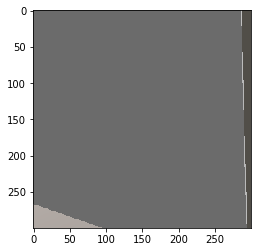

In [12]:
plt.imshow(np.asarray(env_info.visual_observations)[0][0])

episode 1
0
1
2
3
learning!
4
5
6
7
learning!
8
9
10
11
learning!
12
13
14
15
learning!
16
17
18
19
learning!
20
21
22
23
learning!
24
25
26
27
learning!
28
29
30
31
learning!
32
33
34
35
learning!
36
37
38
39
learning!
40
41
42
43
learning!
44
45
46
47
learning!
48
49
50
51
learning!
52
53
54
55
learning!
56
57
58
59
learning!
60
61
62
63
learning!
64
65
66
67
learning!
68
69
70
71
learning!
72
73
74
75
learning!
76
77
78
79
learning!
80
81
82
83
learning!
84
85
86
87
learning!
88
89
90
91
learning!
92
93
94
95
learning!
96
97
98
99
learning!
100
101
102
103
learning!
104
105
106
107
learning!
108
109
110
111
learning!
112
113
114
115
learning!
116
117
118
119
learning!
120
121
122
123
learning!
124
125
126
127
learning!
128
129
130
131
learning!
132
133
134
135
learning!
136
137
138
139
learning!
140
141
142
143
learning!
144
145
146
147
learning!
148
149
150
151
learning!
152
153
154
155
learning!
156
157
158
159
learning!
160
161
162
163
learning!
164
165
166
167
learning!
168
169


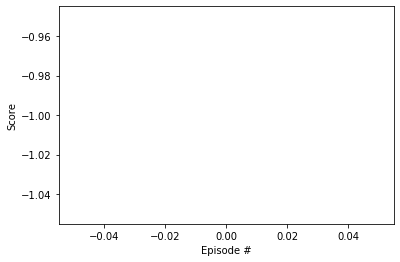

In [13]:

# plot the scores
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(len(scores)), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()

In [ ]:
print(agent.chck[1])

In [ ]:
agent.qnetwork_local(agent.chck[0].unsqueeze(0))

### Watch the agent running ( Using saved weights)

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load(model_weight_name))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

### Close Unity ML Environment

In [18]:
env.close()